# Import packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

# Standard packages
import pandas as pd
import numpy as np
import pickle

# Sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# LGBM
from lightgbm import LGBMRegressor

# Keras
from keras.layers import (Input, Embedding, Flatten, Dot, Dense, Concatenate, 
                          Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D)
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model

# Plotly
import plotly.express as px

Using TensorFlow backend.
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pa/.virtualenvs/groover/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pa/.virtualenvs/groover/lib/p

# Load data

In [2]:
sub = pd.read_csv('./data/raw/submission_history.csv')

# Load embeddings

In [3]:
embeddings_index = {}
with open('./cc.fr.300.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


# Vectorize text samples into a 2D integer tensor

In [4]:
texts = sub.track_info.fillna('Inconnu').values

MAX_NUM_WORDS = max([len(text) for text in texts])
MAX_SEQUENCE_LENGTH  = 440
EMBEDDING_DIM = 300

In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 38848 unique tokens.


# Prepare embedding matrix

In [6]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Define split and data

In [7]:
N_FOLDS = 5
RANDOM_SEED = 42

dataset = pd.read_csv('./data/preprocessed/merged_dataset.csv')
X = dataset.drop(columns=['id', 'track_id', 'band_id', 'influencer_id', 'score'])
y = dataset.score
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [8]:
band_data = X.filter(regex='_band')
influencer_data = X.filter(regex='_influencer')

influencer_kind = X.influencer_kind
i_kind_idx = X.columns.get_loc('influencer_kind')

b_data_idx = [X.columns.get_loc(c) for c in band_data]
i_data_idx = [X.columns.get_loc(c) for c in influencer_data]

# Define Model

In [28]:
def build_Text_model(
    i_emb_dim=16, 
    b_emb_dim=16, 
    kind_emb_dim=8,
    n_kernels=64,
    conv_dense=8,
    last_dense=16, 
    dropout=0.2,
    activation='relu'
):
    """
    Build Neural Network with NLP 1DCNN.
    """
    # Influencer embedding
    influencer_input = Input(shape=[influencer_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation=activation, name="Influencer-Embedding")(influencer_input)
    influencer_embedding = Dropout(rate=dropout)(influencer_embedding)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(
        influencer_kind.nunique(), 
        kind_emb_dim, 
        name="Influencer-Kind-Embedding"
    )(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(name="Influencer-Full-Embedding", axis=-1)(
        [influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)]
    )
    
    # Band embedding
    band_input = Input(shape=[band_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation=activation, name="Band-Embedding")(band_input)
    band_embedding = Dropout(rate=dropout)(band_embedding)
    
    # Track embedding
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(n_kernels, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(rate=dropout)(x)
    x = Conv1D(n_kernels, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(rate=dropout)(x)
    x = Conv1D(n_kernels, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=dropout)(x)
    seq_emb = Dense(conv_dense, activation='relu')(x)
    
    # Concatenate and create product
    concat = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding, seq_emb])
    dense = Dense(last_dense, activation=activation, name="Dense")(concat)
    
    # Dropout
    dropout = Dropout(rate=dropout)(dense)
    
    # Output
    output = Dense(1, activation=activation, name="Output")(dropout)
    band_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                 band_embedding)
    influencer_embedding_model = Model([influencer_input, band_input, influencer_kind_input, sequence_input],
                                       influencer_full_emb)
    model = Model([influencer_input, band_input, influencer_kind_input, sequence_input], output)
    model.compile('adam', 'mean_squared_error')
    
    return model, band_embedding_model, influencer_embedding_model

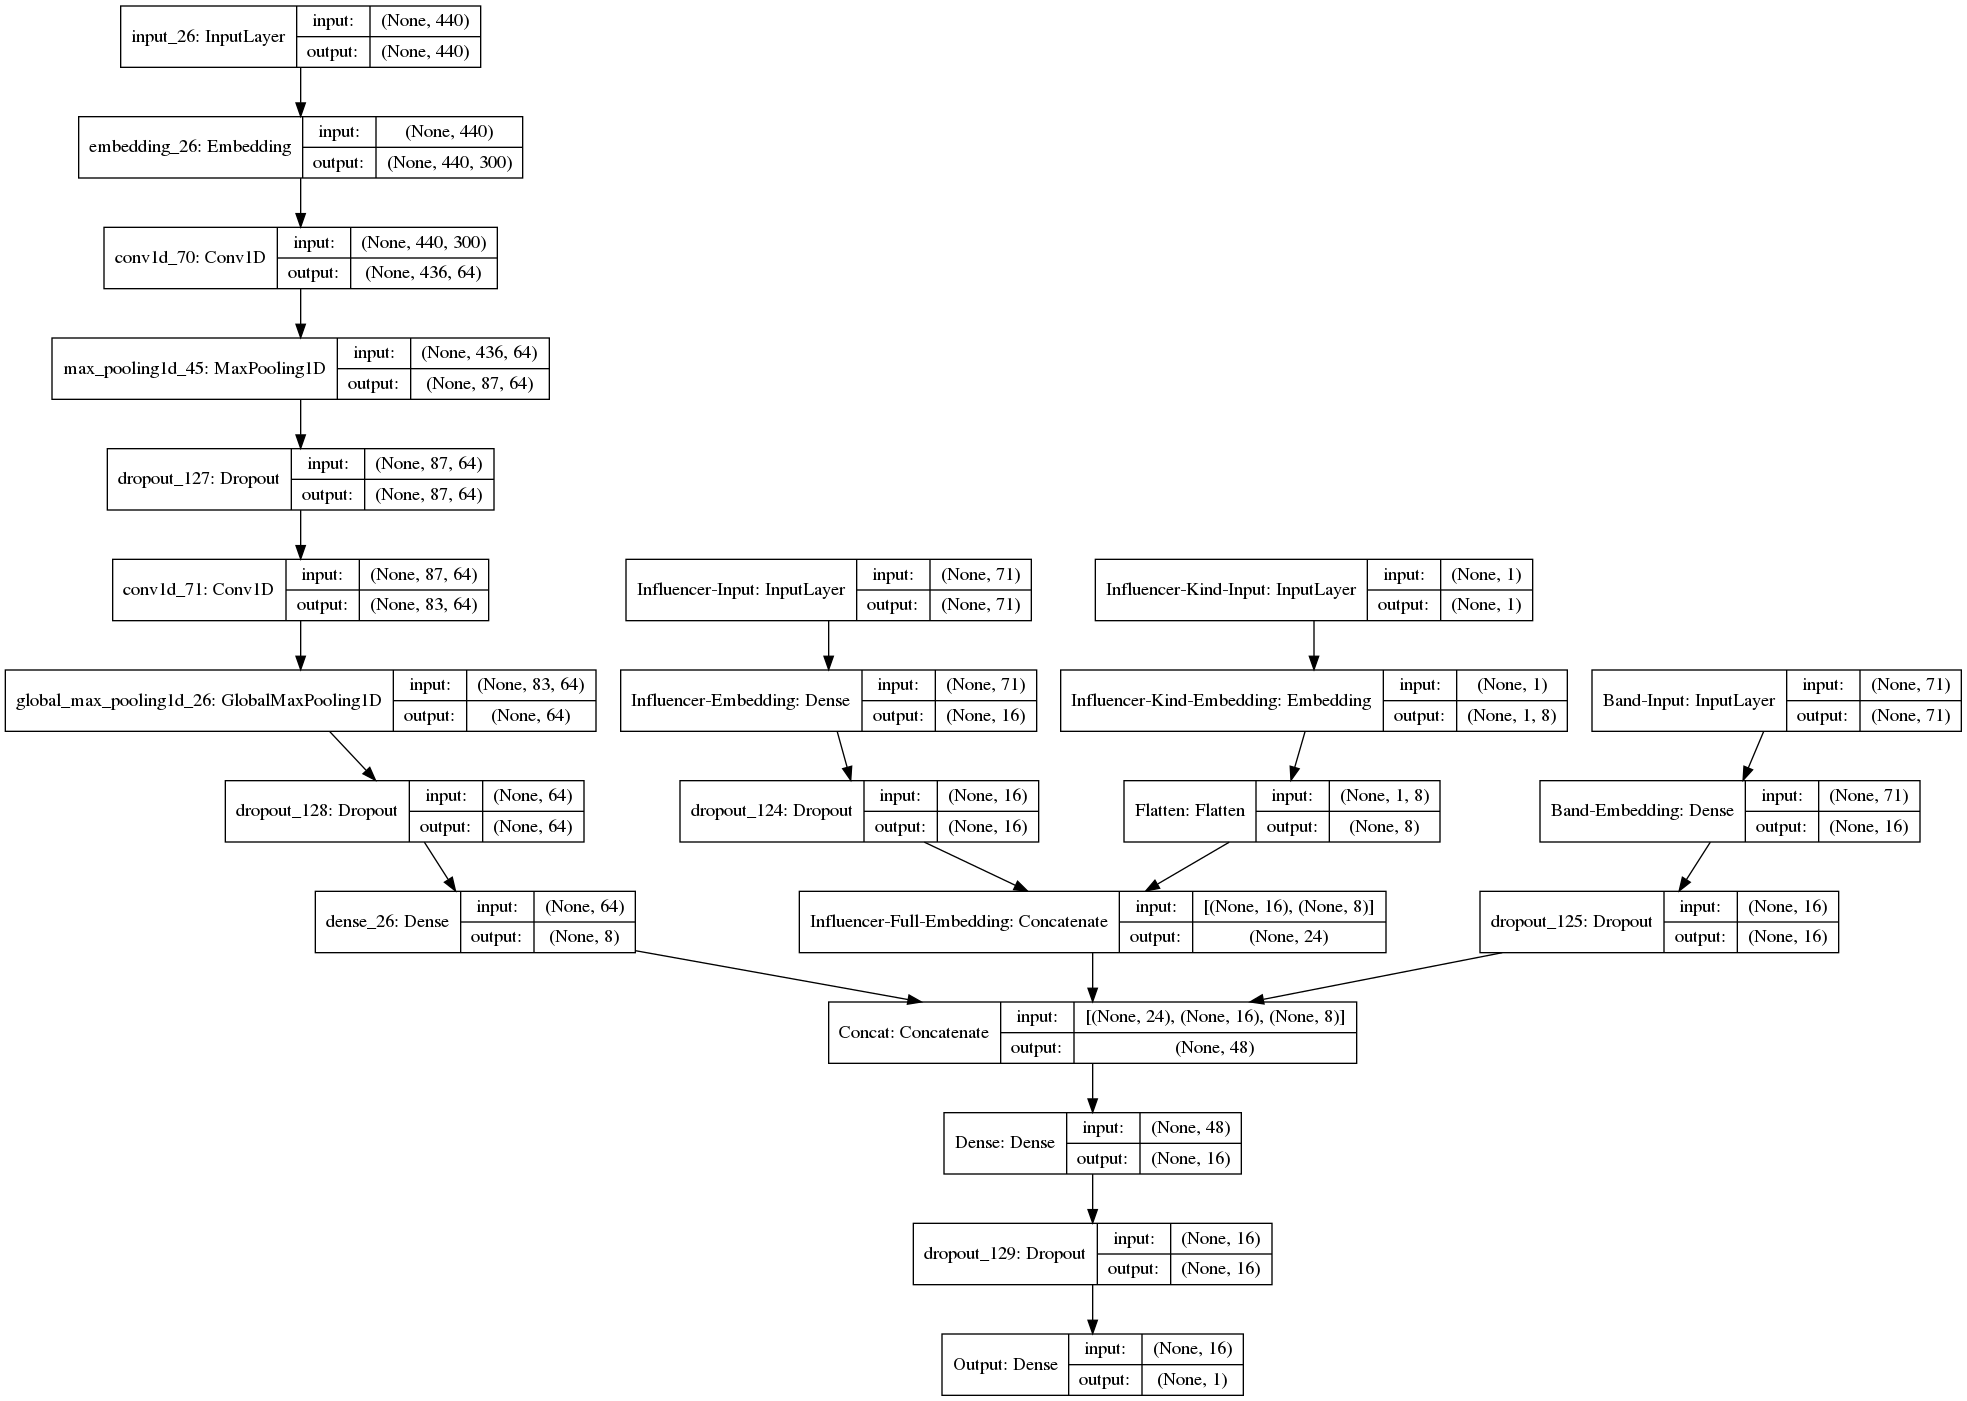

In [29]:
# Plot architecture
model, band_embedding_model, influencer_embedding_model = build_Text_model(dropout=0.2)
plot_model(model, to_file='Text_model_plot.png', show_shapes=True, show_layer_names=True)

# Train model

In [26]:
EPOCHS = 200
PATIENCE = 20
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    docs_train, docs_test = data[train_index], data[test_index]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    docs_train, docs_valid = docs_train[tridx], docs_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_Text_model(dropout=0.1)
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Reduce Learning Rate on Plateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5)
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx], docs_train], 
              y_train,
              validation_data=([X_valid[:, i_data_idx], 
                                X_valid[:, b_data_idx], 
                                X_valid[:, i_kind_idx],
                                docs_valid], 
                               y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es, reduce_lr],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx], docs_test]), 
        y_test
    ))

nn_score /= N_FOLDS

Train on 60267 samples, validate on 6697 samples
Epoch 1/200
60267/60267 [==============================] - 27s 442us/step - loss: 0.1259 - val_loss: 0.1079
Epoch 2/200
60267/60267 [==============================] - 24s 406us/step - loss: 0.1088 - val_loss: 0.1009
Epoch 3/200
60267/60267 [==============================] - 24s 403us/step - loss: 0.1055 - val_loss: 0.0980
Epoch 4/200
60267/60267 [==============================] - 24s 405us/step - loss: 0.1031 - val_loss: 0.0972
Epoch 5/200
60267/60267 [==============================] - 24s 401us/step - loss: 0.1017 - val_loss: 0.0966
Epoch 6/200
60267/60267 [==============================] - 24s 402us/step - loss: 0.1008 - val_loss: 0.0957
Epoch 7/200
60267/60267 [==============================] - 25s 412us/step - loss: 0.0998 - val_loss: 0.0960
Epoch 8/200
60267/60267 [==============================] - 24s 406us/step - loss: 0.0983 - val_loss: 0.0956
Epoch 9/200
60267/60267 [==============================] - 24s 403us/step - loss: 0.098

60268/60268 [==============================] - 25s 416us/step - loss: 0.0998 - val_loss: 0.0934
Epoch 10/200
60268/60268 [==============================] - 25s 411us/step - loss: 0.0988 - val_loss: 0.0937
Epoch 11/200
60268/60268 [==============================] - 25s 419us/step - loss: 0.0984 - val_loss: 0.0935
Epoch 12/200
60268/60268 [==============================] - 25s 415us/step - loss: 0.0979 - val_loss: 0.0924
Epoch 13/200
60268/60268 [==============================] - 25s 412us/step - loss: 0.0977 - val_loss: 0.0924
Epoch 14/200
60268/60268 [==============================] - 25s 419us/step - loss: 0.0978 - val_loss: 0.0932
Epoch 15/200
60268/60268 [==============================] - 25s 413us/step - loss: 0.0972 - val_loss: 0.0938
Epoch 16/200
60268/60268 [==============================] - 25s 416us/step - loss: 0.0968 - val_loss: 0.0928
Epoch 17/200
60268/60268 [==============================] - 25s 418us/step - loss: 0.0968 - val_loss: 0.0933
Epoch 18/200
60268/60268 [======

In [27]:
print(nn_score)

0.30793406935146106
